In [1]:
onedrive = r"C:\Users\mikek\OneDrive"
# %matplotlib ipympl
# %matplotlib qt
# %matplotlib widget
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
import matplotlib as mpl

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# IO

In [2]:
rates = pd.read_csv(os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\Lot 2\Cooling curves\Ar_0.5ms_DM.csv")).astype(float)
# rates = rates.set_index("T")
rates.columns = ["T", "david"]


def RyokoArgon(T):
    answer = 0
    if T >= 1.5 and T<= 100:
        answer = -4.9692e-48*T**10 + 2.8025e-45*T**9 -6.7148e-43*T**8 + 8.8636e-41*T**7 -6.9642e-39*T**6 +3.2559e-37*T**5 -8.3410e-36*T**4 +8.6011e-35*T**3 +1.9958e-34*T**2 + 4.9864e-34*T -9.9412e-34
    elif T >= 1.0 and T< 1.5:
        answer = 2.5E-35/(1.5-1.0)*(T-1.0)
    else:
        answer = 0
    return answer

rates["ryoko"] = rates["T"].apply(RyokoArgon)

rates = rates[(rates["david"] != 0) & (rates["T"]<2000)].copy()    # Get rid of zeros
rates["logT"] = np.log(rates["T"])

## Plot rates

Text(0.5, 1.0, '0-3eV')

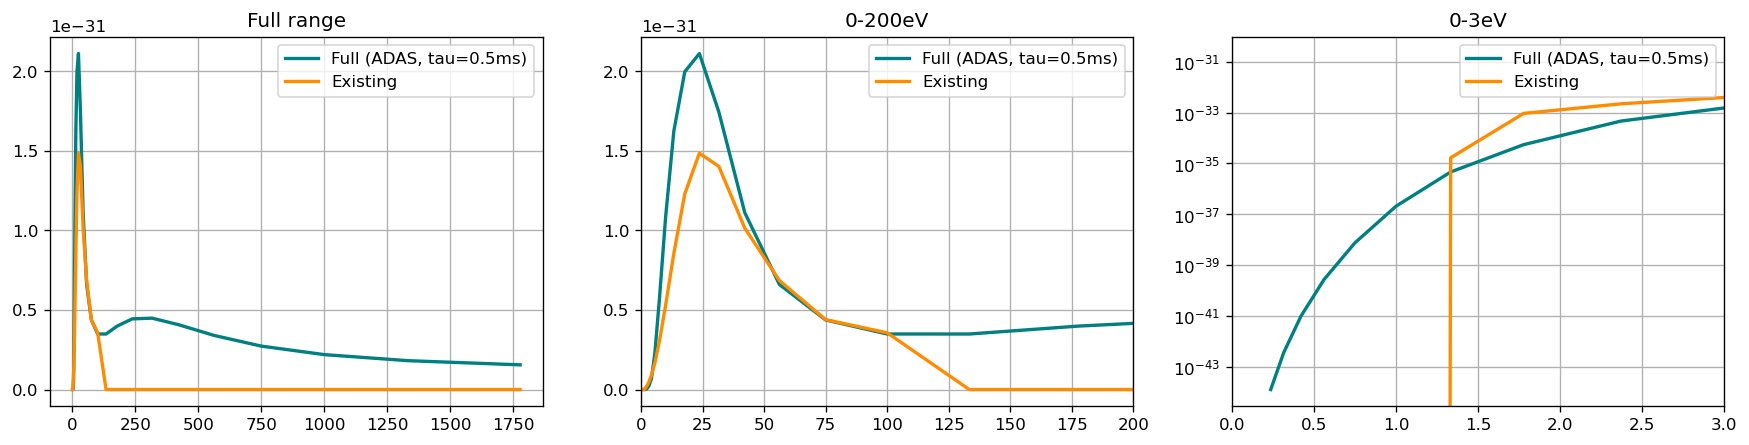

In [12]:

fig, axes = plt.subplots(1,3, figsize=(6*3, 4), dpi = 120)
for ax in axes:
    ax.plot(rates["T"], rates["david"], label = "Full (ADAS, tau=0.5ms)", color = "teal", lw = 2)
    ax.plot(rates["T"], rates["ryoko"], label = "Existing", color = "darkorange", lw = 2)
    ax.legend()
    ax.grid()

ax = axes[0]

ax.set_title("Full range")
axes[1].set_xlim(0,200)
axes[1].set_title("0-200eV")
ax = axes[2]
ax.set_xlim(0,3)
ax.set_yscale("log")
ax.set_title("0-3eV")


Text(0.5, 1.0, '0-3eV')

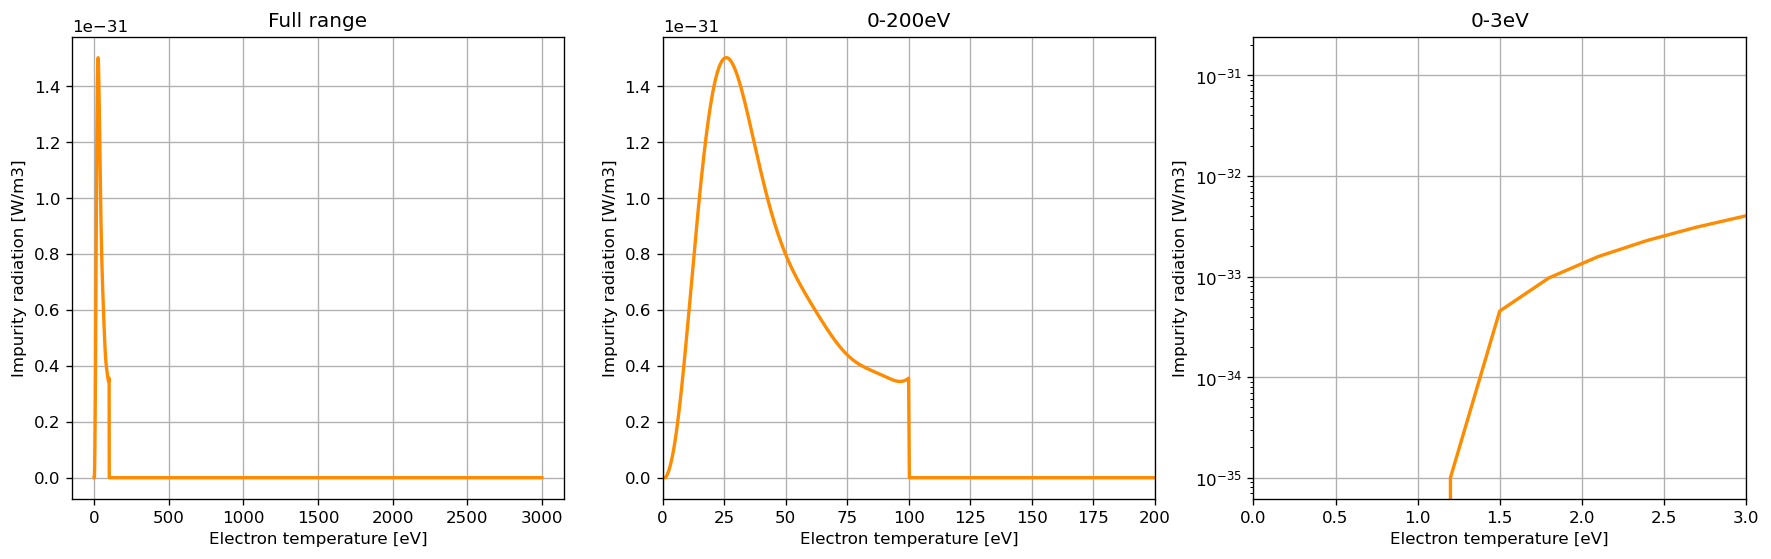

In [5]:
T = np.linspace(0, 3000, 10000)
data = [RyokoArgon(x) for x in T]

fig, axes = plt.subplots(1,3, figsize=(6*3, 5), dpi = 120)
for ax in axes:
    # ax.plot(rates["T"], rates["david"], label = "Full (ADAS, tau=0.5ms)", color = "teal", lw = 2)
    ax.plot(T, data, label = "Existing", color = "darkorange", lw = 2)
    # ax.legend()
    ax.grid()
    ax.set_xlabel("Electron temperature [eV]")
    ax.set_ylabel("Impurity radiation [W/m3]")

ax = axes[0]

ax.set_title("Full range")
axes[1].set_xlim(0,200)
axes[1].set_title("0-200eV")
ax = axes[2]
ax.set_xlim(0,3)
ax.set_yscale("log")
ax.set_title("0-3eV")


# Fit rates

## Fit David's rate in log-log space

C:\Users\mikek\AppData\Local\Temp\ipykernel_29320\4057931608.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


Text(0.5, 1.0, '0-3eV')

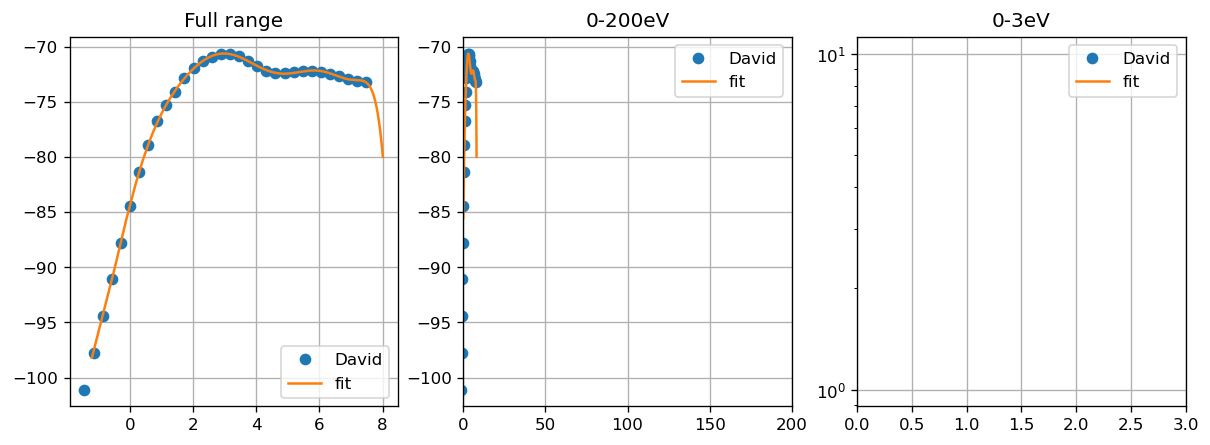

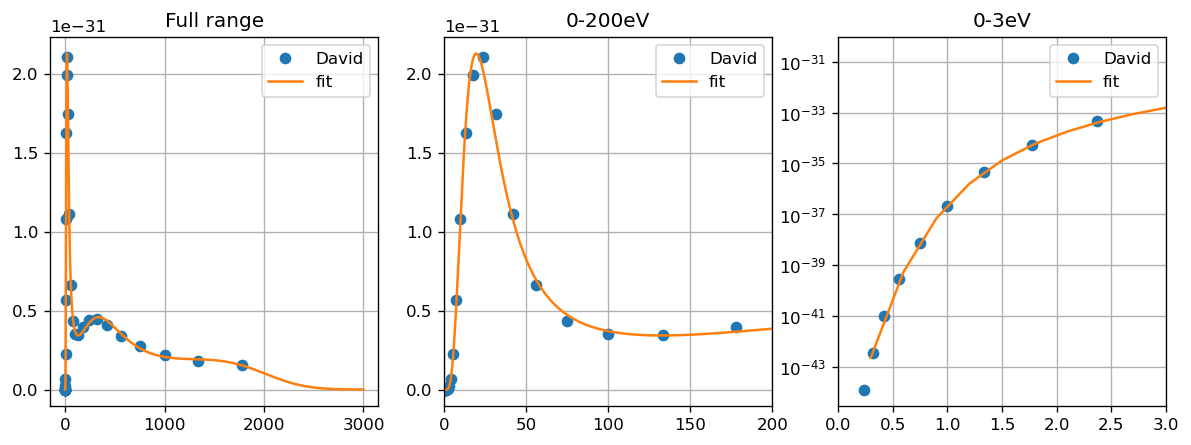

In [14]:


logrates = rates.copy().drop(columns = "ryoko")
logrates["david"] = np.log(rates["david"])

T = rates["T"]
logT = np.log(T)
hires_T = np.linspace(0, 3000, 10000)
hires_logT = np.log(hires_T)

coeffs = np.polyfit(logT, np.log(rates["david"]), deg = 10)[::-1]    # polyfit gives coeffs in opposite order to what polynomial needs
fit_func = np.polynomial.polynomial.Polynomial(coeffs)
logfit = [fit_func(x) for x in hires_logT]

fig, axes = plt.subplots(1,3, figsize=(6*2, 4), dpi = 120)
for ax in axes:
    ax.plot(logT, logrates["david"], label = "David", marker = "o", lw = 0)
    ax.plot(hires_logT, logfit, label = "fit")
    ax.legend()
    ax.grid()

ax = axes[0]
ax.set_title("Full range")
axes[1].set_xlim(0,200)
axes[1].set_title("0-200eV")
ax = axes[2]
ax.set_xlim(0,3)
ax.set_yscale("log")
ax.set_title("0-3eV")

fig, axes = plt.subplots(1,3, figsize=(6*2, 4), dpi = 120)
for ax in axes:
    ax.plot(T, rates["david"], label = "David", marker = "o", lw = 0)
    ax.plot(hires_T, np.exp(logfit), label = "fit")
    ax.legend()
    ax.grid()

ax = axes[0]


ax.set_title("Full range")
axes[1].set_xlim(0,200)
axes[1].set_title("0-200eV")
ax = axes[2]
ax.set_xlim(0,3)
ax.set_yscale("log")
ax.set_title("0-3eV")

## Validation

In [3]:

toload = {
    "test" : "step-1b-0.005ar-coolingtest",
    
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(os.path.join(onedrive_path, rf"Project\collab\tech\cases\step1d_cooling_curve_test\{toload[name]}"))


Loading step-1b-0.005ar-coolingtest


In [18]:
def hermes_ar(Te):
    
    logT = np.log(Te)
    log_out = 0

    if Te >= 0.2 and Te <= 2500:
        log_out = log_out \
        -8.4367e+01 * logT**0 \
        +1.1075e+01 * logT**1 \
        -2.3092e+00 * logT**2 \
        -1.2378e+00 * logT**3 \
        +8.4987e-01 * logT**4 \
        +5.6445e-02 * logT**5 \
        -2.0179e-01 * logT**6 \
        +7.4687e-02 * logT**7 \
        -1.2541e-02 * logT**8 \
        +1.0245e-03 * logT**9 \
        -3.3029e-05 * logT**10 \
    
        return np.exp(log_out)
    

    elif (Te < 0.2):
        return 0;    # Already really near zero
    elif (Te > 2500):
        return 1.2856e-33
    
    
test(500)

6.500440927408195e-32

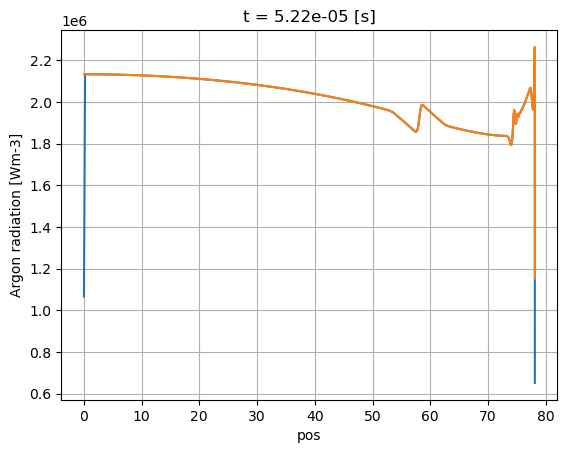

In [20]:
ds = cs["test"].ds.isel(pos = slice(1,-1)).isel(t=-1)

Te = ds["Te"]
Ne = ds["Ne"]
Ni = Ne * 0.005

R = Ne.values * Ni.values * np.array([hermes_ar(x) for x in Te.values])

fig, ax = plt.subplots()
ax.grid()
ds["Rar"].plot(ax = ax, label = "Code")
ax.plot(ds["pos"], R)

# R = [test()]

In [216]:
for i, x in enumerate(coeffs):
    print(f"{x:+.4e} * pow(logT, {i})")
# coeffs

-8.4367e+01 * pow(logT, 0)
+1.1075e+01 * pow(logT, 1)
-2.3092e+00 * pow(logT, 2)
-1.2378e+00 * pow(logT, 3)
+8.4987e-01 * pow(logT, 4)
+5.6445e-02 * pow(logT, 5)
-2.0179e-01 * pow(logT, 6)
+7.4687e-02 * pow(logT, 7)
-1.2541e-02 * pow(logT, 8)
+1.0245e-03 * pow(logT, 9)
-3.3029e-05 * pow(logT, 10)


<Axes: >

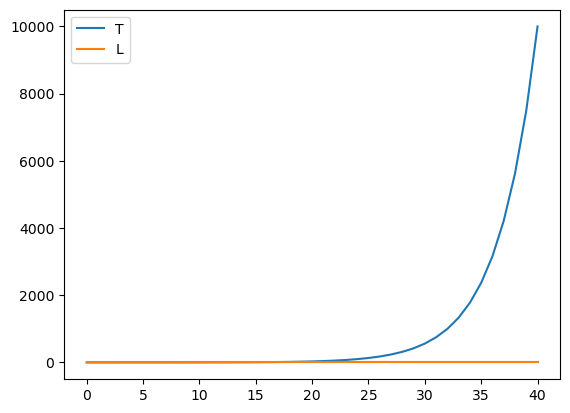

In [6]:
dm_rate.plot()